In [1]:
# Install relevant libraries
!pip install numpy matplotlib tqdm celluloid

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib notebook

# Problem Statement

In this section we will implement tabular SARSA and Q-learning algorithms for a grid world navigation task.

## Environment details
The agent can move from one grid coordinate to one of its adjacent grids using one of the four actions: UP, DOWN, LEFT and RIGHT. The goal is to go from a randomly assigned starting position to goal position.

Actions that can result in taking the agent off the grid will not yield any effect.
Lets look at the environment.


In [86]:
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
actions = [UP, DOWN, LEFT, RIGHT]

Let us construct a grid in a text file.

In [87]:
!cat grid_world.txt

0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0
2 2 2 2 0 0 0 0
2 2 2 2 0 0 0 0
0 0 0 0 0 0 0 0
0 0 2 2 2 0 0 0
0 0 2 2 2 0 0 0


This is a $17\times 23$ grid. The reward when an agent goes to a cell is negative of the value in that position in the text file (except if it is the goal cell). We will define the goal reward as 10. We will also fix the maximum episode length to 10000.

Now let's plot the grid world.

<IPython.core.display.Javascript object>


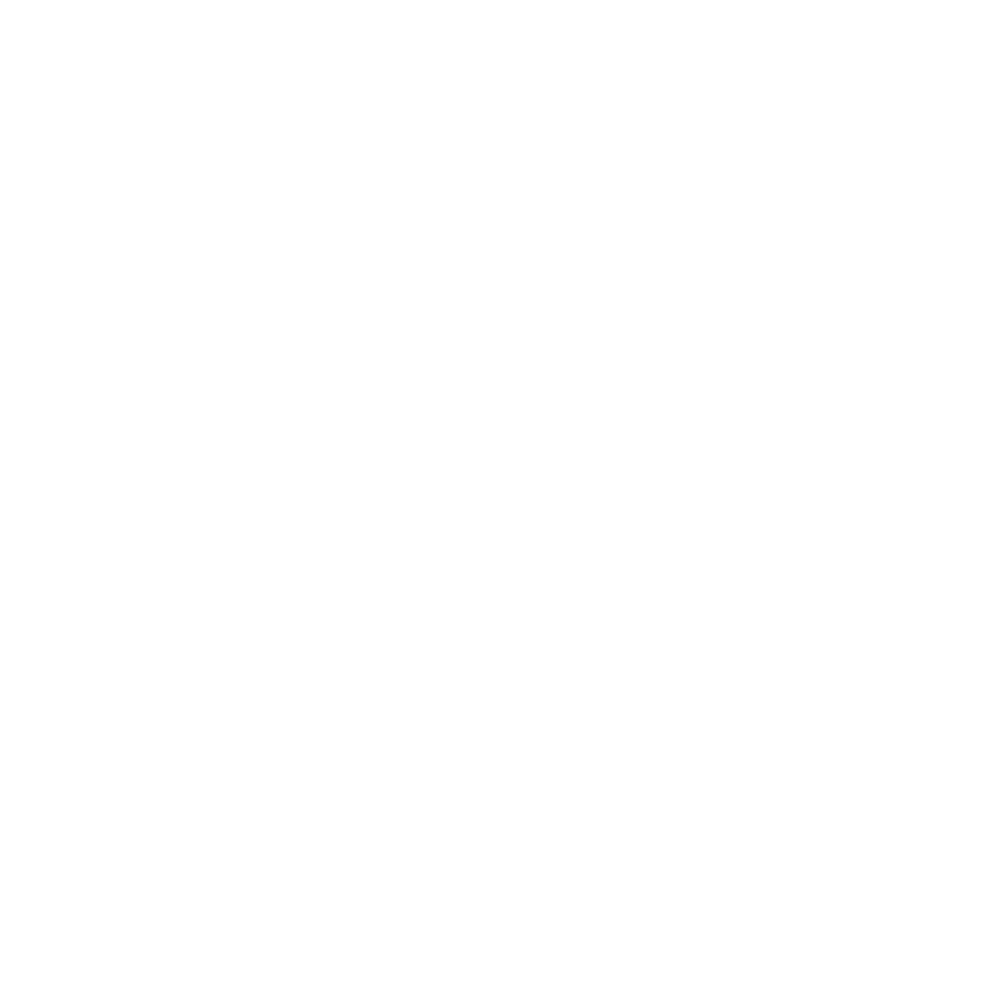

In [109]:
world = 'grid_world2.txt'
goal_reward = 10
start_states = [(0,0)]
goal_states=[(10,10)]
max_steps=10000

from grid_world import GridWorldEnv
env = GridWorldEnv(world, goal_reward=goal_reward, start_states=start_states, goal_states=goal_states,
                max_steps=max_steps)
plt.figure(figsize=(10, 10))
env.step(DOWN)
env.render(ax=plt, render_agent=True)

### Legend
- <span style="color:#0004FF">*Blue*</span> is the **start state**.
- <span style="color:#00FF23">*Green*</span> is the **goal state**.
- <span style="color:#F0FF00">*Yellow*</span> is current **state of the agent**.
- <span style="color:#FF2D00">*Redness*</span> denotes the extent of **negative reward**.

### Q values
We can use a 3D array to represent Q values. The first two indices are X, Y coordinates and last index is the action.

In [110]:
Q = np.zeros((env.grid.shape[0], env.grid.shape[1], len(env.action_space)))
Q.shape

(17, 23, 4)

## SARSA
Now we implement the SARSA algorithm.
Recall that the update rule for SARSA:
        $$Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)]$$
So we have som hyperparameters for the algorithm:
- $\alpha$
- number of *episodes*.
- $\epsilon$: For epsilon greedy exploration

### Hyperparameters and exploration strategy

In [111]:
alpha0 = 0.5
gamma = 0.9
episodes = 100000
epsilon0 = 0.3
seed = 0
epsilon_decay_rate = 0.0001
alpha_decay_rate = 0.0001
rg = np.random.RandomState(seed)

# Epsilon greedy exploration

def choose_action(Q, state, epsilon=epsilon, rg=rg):
    if not Q[state[0], state[1]].any() or rg.rand() < epsilon:
        return rg.choice(Q.shape[-1])
    else:
        return np.argmax(Q[state[0], state[1]])

Let's implement SARSA

In [117]:
print_freq = 1000
episode_rewards = np.zeros(episodes)
steps_to_completion = np.zeros(episodes)

%matplotlib gtk

def sarsa(env, Q, gamma = 0.9):
    #episode_rewards = np.zeros(episodes)
    #steps_to_completion = np.zeros(episodes)
    plt.figure()
    plt.pcolor(np.flip(Q.max(-1), 0), edgecolors='k', linewidths=2)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = env.reset()
        action = choose_action(Q, state, epsilon)
        done = False
        while not done:
            state_next, reward, done = env.step(action)
            action_next = choose_action(Q, state_next, epsilon)
            
            # update equation
            Q[state[0], state[1], action] += alpha*(reward + gamma*Q[state_next[0], state_next[1], action_next] - Q[state[0], state[1], action])
                                                    
            tot_reward += reward
            steps += 1
            
            state, action = state_next, action_next
        epsilon *= (1-epsilon_decay_rate)
        alpha *= (1-alpha_decay_rate)
    
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1)%print_freq == 0:
            print("Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
            print("Epsilon: %f, Alpha: %f"%(epsilon, alpha))
            plt.clf()
            plt.pcolor(np.flip(Q.max(-1), 0), edgecolors='k', linewidths=2)
    
    return Q, episode_rewards, steps_to_completion


<IPython.core.display.Javascript object>


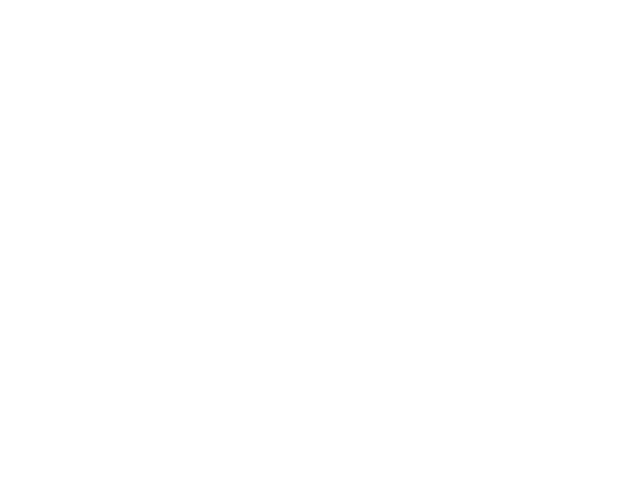

KeyboardInterrupt: 

In [115]:
Q, rewards, steps = sarsa(env, Q)

In [48]:
rg.rand()

0.5356171625636752

## Q-Learning
Now we implement the Q-Learning algorithm.
Recall that the update rule for SARSA:
        $$Q(s_t,a_t) \leftarrow  Q(s_t, a_t) + \alpha[r_t + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)]$$

In [49]:
print_freq = 1000
def qlearn(env, Q, gamma = 0.9):
    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    epsilon = epsilon0
    alpha = alpha0
    for ep in range(episodes):
        tot_reward, steps = 0, 0
        
        # Reset environment
        state = env.reset()
        
        done = False
        while not done:
            action = choose_action(Q, state, epsilon)
            state_next, reward, done = env.step(action)
            
            # update equation
            Q[state[0], state[1], action] += alpha*(reward + gamma*Q[state_next[0], state_next[1]].max() \
                                                    - Q[state[0], state[1], action])
            tot_reward += reward
            steps += 1
            
            state = state_next
        epsilon *= (1-epsilon_decay_rate)
        alpha *= (1-alpha_decay_rate)
    
        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps
        
        if (ep+1)%print_freq == 0:
            print("Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
    return Q, episode_rewards, steps_to_completion


In [50]:
Q, rewards, steps = qlearn(env, Q)

/home/priyeshv/anaconda3/envs/harsha/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/priyeshv/anaconda3/envs/harsha/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 1000: Reward: nan, Steps: nan, Qmax: 10.000000, Qmin: -2.086935
Episode 2000: Reward: 9.308000, Steps: 17.650000, Qmax: 10.000000, Qmin: -1.922952
Episode 3000: Reward: 8.456000, Steps: 18.212000, Qmax: 10.000000, Qmin: -1.922952
Episode 4000: Reward: 8.182000, Steps: 18.019000, Qmax: 10.000000, Qmin: -1.909140
Episode 5000: Reward: 7.966000, Steps: 17.611000, Qmax: 10.000000, Qmin: -1.909140
Episode 6000: Reward: 7.674000, Steps: 17.646000, Qmax: 10.000000, Qmin: -1.909140
Episode 7000: Reward: 7.818000, Steps: 17.871000, Qmax: 10.000000, Qmin: -1.909140
Episode 8000: Reward: 7.908000, Steps: 17.795000, Qmax: 10.000000, Qmin: -1.909140
Episode 9000: Reward: 7.870000, Steps: 17.703000, Qmax: 10.000000, Qmin: -1.909140
Episode 10000: Reward: 7.836000, Steps: 17.740000, Qmax: 10.000000, Qmin: -1.909140


In [51]:
steps[0:100]

array([24., 17., 27., 13., 21., 17., 26., 15., 25., 12., 20., 20., 17.,
       20., 28., 21., 16., 19., 18., 18., 19., 14., 25., 33., 18., 14.,
       26., 13., 12., 12., 26., 22., 18., 13., 21., 14., 24., 15., 14.,
       15., 21., 20., 18., 23., 17., 26., 18., 14., 21., 14., 15., 12.,
       28., 26., 12., 21., 13., 19., 15., 14., 18., 16., 14., 15., 12.,
       28., 21., 13., 17., 12., 16., 19., 15., 12., 14., 23., 20., 19.,
       14., 25., 16., 16., 13., 14., 14., 24., 19., 14., 23., 18., 17.,
       16., 25., 14., 16., 13., 12., 14., 21., 18.])

In [93]:
Q.max(-1).shape

(17, 23)